In [1]:
# =================================================================
# BLOK 1: Kurulum, Kütüphane İçe Aktarma ve Drive Bağlantısı
# =================================================================

# GEREKLİ TÜM KÜTÜPHANELERİ İÇE AKTARMA
import os
import numpy as np
import cv2
from imutils import paths
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# CNN için TensorFlow ve Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical


# TARGET BOYUTU VE SINIF ETİKETLERİ TANIMLAMA
target_size = (224, 224)
waste_labels= {'cardboard': 0 , 'glass': 1 , 'metal' : 2 , 'paper' : 3 , 'plastic' : 4 ,'trash': 5}
NUM_CLASSES = len(waste_labels)
CLASS_NAMES = list(waste_labels.keys())

print("Gerekli kütüphaneler başarıyla içe aktarıldı.")


# GOOGLE DRIVE'I COLAB ORTAMINA BAĞLAMA
print("\nGoogle Drive Bağlantısı Başlatılıyor...")
from google.colab import drive
# Önceki hataları önlemek için 'unmount' ve 'mount' kombinasyonu:
try:
    drive.unmount('/content/drive')
except:
    pass
drive.mount('/content/drive')
print("Drive bağlandı!")

Gerekli kütüphaneler başarıyla içe aktarıldı.

Google Drive Bağlantısı Başlatılıyor...
Mounted at /content/drive
Drive bağlandı!


In [2]:
# =================================================================
# BLOK 2: Verisetini Çıkarma ve Yükleme Fonksiyonu
# =================================================================

# Colab ortamında verisetinin çıkarılacağı klasör
EXTRACTION_PATH = '/content/garbage_classification_data/'
# Drive'daki zip dosyasının yolu. (Kullanıcı tarafından onaylandı)
ZIP_FILE_PATH = '/content/drive/MyDrive/archive.zip'
DATA_DIR = EXTRACTION_PATH


print("Verisetinin çıkarılacağı klasör oluşturuluyor...")
!mkdir -p {EXTRACTION_PATH}

print("Verisetinin çıkarılması başlatılıyor...")
!unzip -q {ZIP_FILE_PATH} -d {EXTRACTION_PATH}

print("Veriseti başarıyla çıkarıldı ve Colab'da kullanıma hazır!")

# Veri Yükleme Fonksiyonu
def load_datasets(path, target_size, waste_labels):
    x = []
    labels = []
    image_paths = sorted(list(paths.list_images(path)))

    for image_path in image_paths:
        try:
            image = cv2.imread(image_path)
            if image is None: continue

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, target_size)
            x.append(image)

            label_name = image_path.split(os.path.sep)[-2]
            if label_name in waste_labels:
                labels.append(waste_labels[label_name])
            else:
                pass
        except Exception as e:
            continue

    x, labels = shuffle(x, labels, random_state=42)
    x = np.array(x)
    labels = np.array(labels)
    print("-" * 30)
    print(f"X (Görüntüler) boyutu: {x.shape}")
    print(f"Label (Etiketler) gözlem sayısı: {len(labels)}")
    print("-" * 30)

    return x, labels

# Veriyi Yükleme
try:
    x, labels = load_datasets(DATA_DIR, target_size, waste_labels)
except Exception as e:
    print(f"\nVeri yüklenirken bir hata oluştu: {e}")

Verisetinin çıkarılacağı klasör oluşturuluyor...
Verisetinin çıkarılması başlatılıyor...
Veriseti başarıyla çıkarıldı ve Colab'da kullanıma hazır!
------------------------------
X (Görüntüler) boyutu: (5054, 224, 224, 3)
Label (Etiketler) gözlem sayısı: 5054
------------------------------


In [3]:
# =================================================================
# BLOK 3: Ön İşleme, Normalizasyon ve Veri Artırma
# =================================================================

# 1. Etiketleri One-Hot Encoding formatına dönüştürme
y = to_categorical(labels, num_classes=NUM_CLASSES)

# 2. Görüntüleri 0-1 arasına ölçeklendirme (Normalizasyon)
x_normalized = x.astype("float32") / 255.0

# 3. Veriyi Eğitim ve Test Setlerine Ayırma
(x_train, x_test, y_train, y_test) = train_test_split(
    x_normalized, y, test_size=0.20, random_state=42
)

print(f"Eğitim Verisi Boyutu: {x_train.shape}")
print(f"Test Verisi Boyutu: {x_test.shape}")


# 4. ImageDataGenerator Tanımlama
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)
test_datagen = ImageDataGenerator()

# 5. Jeneratörleri Oluşturma
train_generator = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)
validation_generator = test_datagen.flow(x_test, y_test, batch_size=BATCH_SIZE)

print("ImageDataGenerator'lar başarıyla oluşturuldu.")

Eğitim Verisi Boyutu: (4043, 224, 224, 3)
Test Verisi Boyutu: (1011, 224, 224, 3)
ImageDataGenerator'lar başarıyla oluşturuldu.


In [4]:
# =================================================================
# BLOK 4: CNN Modelinin Tanımlanması ve Derlenmesi
# =================================================================

model = Sequential()

# EVRİŞİM BLOK 1
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(224, 224, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# EVRİŞİM BLOK 2
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# SINIFLANDIRMA AŞAMASI
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=NUM_CLASSES, activation='softmax'))

# MODELİ DERLEME
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    25,690,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,710,406 (98.08 MB)

 Trainable params: 25,710,406 (98.08 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# =================================================================
# BLOK 5: Callbacks (Geri Çağrılar) Tanımlama
# =================================================================

CHECKPOINT_PATH = '/content/drive/MyDrive/CNN_Garbage_Classification/best_cnn_model.keras'

# ModelCheckpoint (EN İYİ MODELİ KAYDETME)
checkpoint_cb = ModelCheckpoint(
    filepath=CHECKPOINT_PATH,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# EarlyStopping (ERKEN DURDURMA)
early_stopping_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    restore_best_weights=True,
    verbose=1
)

callbacks_list = [checkpoint_cb, early_stopping_cb]

print("Callbacks başarıyla tanımlandı.")

Callbacks başarıyla tanımlandı.


In [10]:
# =================================================================
# BLOK 6: Model Eğitimi
# =================================================================

EPOCHS = 100
BATCH_SIZE = 32

steps_per_epoch_val = len(x_train) // BATCH_SIZE
validation_steps_val = len(x_test) // BATCH_SIZE

print("Model eğitimi başlatılıyor...")

# Modeli Eğitme ve 'history' değişkenine sonuçları atama
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_val,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps_val,
    callbacks=callbacks_list
)

print("Model eğitimi tamamlandı ve 'history' değişkeni artık bellekte!")

Model eğitimi başlatılıyor...
Epoch 1/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.4289 - loss: 1.4039
Epoch 1: val_accuracy improved from 0.44355 to 0.46069, saving model to /content/drive/MyDrive/CNN_Garbage_Classification/best_cnn_model.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 49s 387ms/step - accuracy: 0.4290 - loss: 1.4038 - val_accuracy: 0.4607 - val_loss: 1.3111
Epoch 2/100
  1/126 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.4375 - loss: 1.3955

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.46069
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4375 - loss: 1.3955 - val_accuracy: 0.4587 - val_loss: 1.3075
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.4614 - loss: 1.3406
Epoch 3: val_accuracy improved from 0.46069 to 0.50706, saving model to /content/drive/MyDrive/CNN_Garbage_Classification/best_cnn_model.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 85s 417ms/step - accuracy: 0.4615 - loss: 1.3406 - val_accuracy: 0.5071 - val_loss: 1.2603
Epoch 4/100
  1/126 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.3750 - loss: 1.5104
Epoch 4: val_accuracy improved from 0.50706 to 0.50907, saving model to /content/drive/MyDrive/CNN_Garbage_Classification/best_cnn_model.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.3750 - loss: 1.5104 - val_accuracy: 0.5091 - val_loss: 1.2542
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.4749 - loss: 1.3319
Epoch 5: val_accuracy improved from 0.509

Eğitim ve Doğrulama Tarihçesi Grafikleri Oluşturuluyor...


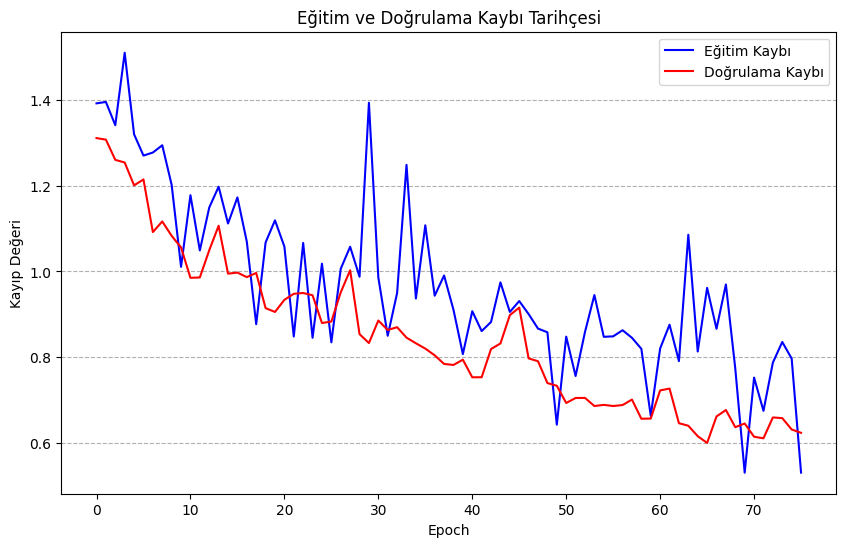

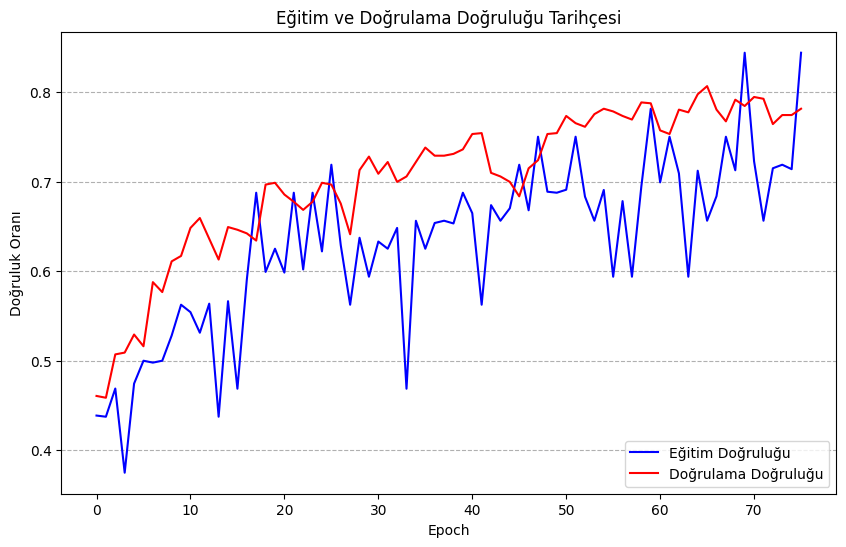


Grafikler Drive'a kaydedildi. Reponuzda paylaşabilirsiniz.


In [11]:
# =================================================================
# BLOK 7: Eğitim Tarihçesi Grafikleri ve Kaydetme
# =================================================================

SAVE_PATH = '/content/drive/MyDrive/CNN_Garbage_Classification/'
os.makedirs(SAVE_PATH, exist_ok=True)

print("Eğitim ve Doğrulama Tarihçesi Grafikleri Oluşturuluyor...")

# --- 1. KAYIP (LOSS) GRAFİĞİ ---
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Eğitim Kaybı', color='blue')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı', color='red')
plt.title('Eğitim ve Doğrulama Kaybı Tarihçesi')
plt.xlabel('Epoch')
plt.ylabel('Kayıp Değeri')
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--')
plt.savefig(SAVE_PATH + 'loss_history.png')
plt.show()

# --- 2. DOĞRULUK (ACCURACY) GRAFİĞİ ---
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu', color='blue')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu', color='red')
plt.title('Eğitim ve Doğrulama Doğruluğu Tarihçesi')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk Oranı')
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--')
plt.savefig(SAVE_PATH + 'accuracy_history.png')
plt.show()

print(f"\nGrafikler Drive'a kaydedildi. Reponuzda paylaşabilirsiniz.")

In [1]:
# =================================================================
# BLOK 8: Model Değerlendirme ve Karışıklık Matrisi
# =================================================================

CHECKPOINT_PATH = '/content/drive/MyDrive/CNN_Garbage_Classification/best_cnn_model.keras'
best_model = tf.keras.models.load_model(CHECKPOINT_PATH)

print("En iyi model başarıyla yüklendi.")

# Final Test Değerlendirmesi
loss, accuracy = best_model.evaluate(x_test, y_test, verbose=1)
print("-" * 40)
print(f"Final Test Doğruluğu: {accuracy*100:.2f}%")
print("-" * 40)

# Tahminleri Al
y_pred_probs = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# --- SINIFLANDIRMA RAPORU ---
print("\n" + "="*25)
print("SINIFLANDIRMA RAPORU")
print("="*25)
print(classification_report(y_true_classes, y_pred_classes, target_names=CLASS_NAMES))


# --- KARIŞIKLIK MATRİSİ (Confusion Matrix) ---
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_df = pd.DataFrame(cm, index=CLASS_NAMES, columns=CLASS_NAMES)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Karışıklık Matrisi')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.show()

NameError: name 'tf' is not defined